!pip install --upgrade dask distributed 
!pip install --upgrade dask
!pip install --upgrade dask distributed tornado
!pip install --upgrade bokeh
!pip install graphviz

In [1]:
import dask.config

# Setting the 'distributed.comm.websockets' configuration
dask.config.set({'distributed.comm.websockets.shard': '16MB'})
dask.config.set({'distributed.comm.tcp.backend': 'tornado'}) # Adjust the size as needed

# Importing the Client
from dask.distributed import Client

In [2]:
client = Client()

In [3]:
data_dir = '/home/patel.devki1/Dataset/lung_colon_image_set/'

In [4]:
import os
from dask import delayed

# Defining the list to store delayed functions for file path extraction and label assignment
delayed_functions = []

# Defining delayed function for extracting file paths and assigning labels
@delayed
def extract_filepaths_and_labels(folder, folderpath):
    filepaths = []
    labels = []

    # Check if folderpath is a directory
    if os.path.isdir(folderpath):
        folderlist = os.listdir(folderpath)
        
        for fileimage in folderlist:
            fileimagepath = os.path.join(folderpath, fileimage)
            filepaths.append(fileimagepath)

            if folder == 'colon_aca':
                labels.append('Colon Adenocarcinoma')
            elif folder == 'colon_n':
                labels.append('Colon Benign Tissue')
            elif folder == 'lung_aca':
                labels.append('Lung Adenocarcinoma')
            elif folder == 'lung_n':
                labels.append('Lung Benign Tissue')
            elif folder == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')
    else:
        print(f"Warning: {folderpath} is not a valid directory.")

    return filepaths, labels

# Getting the list of folders (classes) in the data directory
folders = os.listdir(data_dir)
folders = [f for f in folders if not str(f).__contains__('.ipynb_checkpoints')]

# Creating delayed functions for each folder
for folder in folders:
    folderpath = os.path.join(data_dir, folder)
    delayed_func = extract_filepaths_and_labels(folder, folderpath)
    delayed_functions.append(delayed_func)

# Computing the delayed functions to get the file paths and labels
computed_results = dask.compute(*delayed_functions)

# Unpacking the computed results
filepaths = []
labels = []
for result in computed_results:
    result_filepaths, result_labels = result
    filepaths.extend(result_filepaths)
    labels.extend(result_labels)

# Printing the extracted file paths and labels
print("File Paths:")
print(filepaths[:5])  # Print the first 5 file paths for demonstration
print("Labels:")
print(labels[:5])  # Print the first 5 labels for demonstration


File Paths:
['/home/patel.devki1/Dataset/lung_colon_image_set/colon_aca/.ipynb_checkpoints', '/home/patel.devki1/Dataset/lung_colon_image_set/colon_aca/colonca1.jpeg', '/home/patel.devki1/Dataset/lung_colon_image_set/colon_aca/colonca10.jpeg', '/home/patel.devki1/Dataset/lung_colon_image_set/colon_aca/colonca100.jpeg', '/home/patel.devki1/Dataset/lung_colon_image_set/colon_aca/colonca1000.jpeg']
Labels:
['Colon Adenocarcinoma', 'Colon Adenocarcinoma', 'Colon Adenocarcinoma', 'Colon Adenocarcinoma', 'Colon Adenocarcinoma']


/home/patel.devki1/.local/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33243 instead
  warnings.warn(


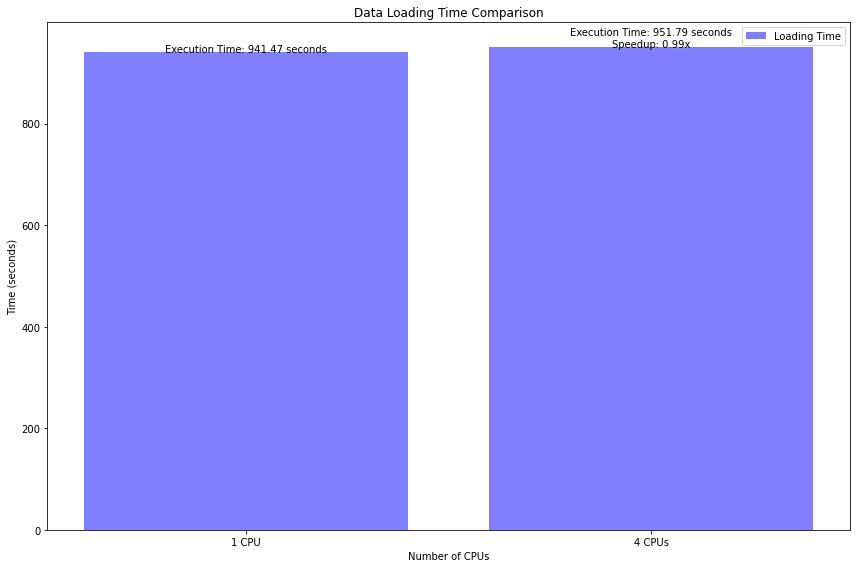

In [5]:
# without batch_size
from dask.distributed import Client
from dask import delayed
import matplotlib.pyplot as plt
import time
import os
import multiprocessing

# Setting up Dask client with a multiprocessing scheduler
client = Client(processes=False)  # False for multiprocessing, True for multithreading

# Defining delayed function for reading image files
@delayed
def read_image(filename):
    # Simulating data loading operation (e.g., reading from disk)
    time.sleep(1)  # Simulate loading time (1 second delay)
    return filename

# Defining a function to load images from subdirectories
def load_images_from_subdirectories(data_dir):
    subdirectories = [os.path.join(data_dir, subdir) for subdir in os.listdir(data_dir) if not subdir.startswith('.')]
    all_filenames = []
    for subdir in subdirectories:
        filenames = [os.path.join(subdir, filename) for filename in os.listdir(subdir) if not filename.startswith('.')]
        all_filenames.extend(filenames)
    return [read_image(filename) for filename in all_filenames]

# Creating delayed tasks for data loading
tasks_1_cpu = load_images_from_subdirectories(data_dir)  # Load images on 1 CPU
tasks_4_cpus = load_images_from_subdirectories(data_dir)  # Load images on 4 CPUs

# Measuring execution time for loading data on 1 CPU
start_time_1_cpu = time.time()
_ = client.compute(tasks_1_cpu)
_ = client.gather(_)  # Wait for data to be computed
end_time_1_cpu = time.time()
execution_time_1_cpu = end_time_1_cpu - start_time_1_cpu

# Measuring execution time for loading data on 4 CPUs
start_time_4_cpus = time.time()
_ = client.compute(tasks_4_cpus)
_ = client.gather(_)  # Wait for data to be computed
end_time_4_cpus = time.time()
execution_time_4_cpus = end_time_4_cpus - start_time_4_cpus

# Calculating speedup
speedup = execution_time_1_cpu / execution_time_4_cpus

# Plotting the speedup
plt.figure(figsize=(12,8))
plt.bar(['1 CPU', '4 CPUs'], [execution_time_1_cpu, execution_time_4_cpus], color='blue', alpha=0.5, label='Loading Time')
plt.xlabel('Number of CPUs')
plt.ylabel('Time (seconds)')
plt.title('Data Loading Time Comparison')
plt.text(0, execution_time_1_cpu - 0.5, f'Execution Time: {execution_time_1_cpu:.2f} seconds', ha='center')
plt.text(1, execution_time_4_cpus - 0.5, f'Execution Time: {execution_time_4_cpus:.2f} seconds\nSpeedup: {speedup:.2f}x', ha='center')
plt.legend()
plt.tight_layout()

# Showing the plot
plt.show()

# Closing the Dask client
client.close()

/home/patel.devki1/.local/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34231 instead
  warnings.warn(


execution_times_1_cpu  [12.330326080322266, 2.8921895027160645, 1.4568593502044678]
execution_times_4_cpu  1.5633399486541748


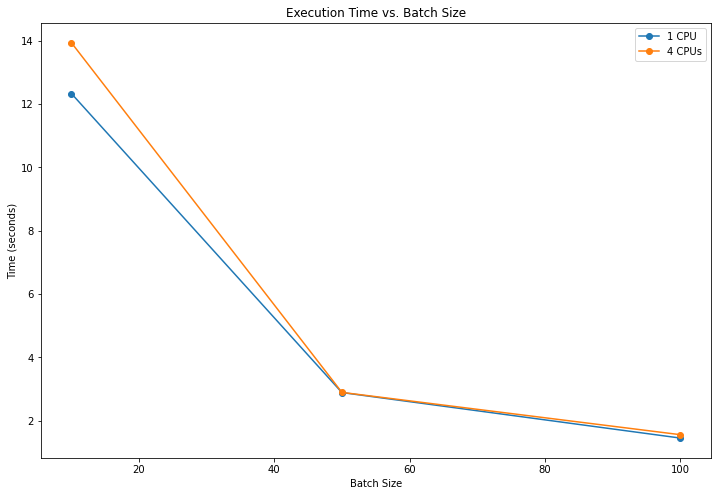

In [13]:
from dask.distributed import Client
from dask import delayed
import matplotlib.pyplot as plt
import time
import os
import multiprocessing

client = Client(processes=False)  # False for multiprocessing, True for multithreading

# Defining delayed function for reading image files
@delayed
def read_image_batch(filenames):
    # Simulate data loading operation (e.g., reading from disk)
    time.sleep(0.1)  # Reduced sleep time for faster simulation
    return filenames

# Defining a function to load images from subdirectories and batch process
def load_images_from_subdirectories_batch(data_dir, batch_size):
    subdirectories = [os.path.join(data_dir, subdir) for subdir in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subdir))]
    all_filenames = []
    for subdir in subdirectories:
        filenames = [os.path.join(subdir, filename) for filename in os.listdir(subdir) if not filename.startswith('.')]
        all_filenames.extend(filenames)
    # Batch process filenames into groups
    batched_filenames = [all_filenames[i:i + batch_size] for i in range(0, len(all_filenames), batch_size)]
    return [read_image_batch(batch) for batch in batched_filenames]

# Experiment with different batch sizes
batch_sizes = [10, 50, 100]  # Adjust as needed

# Measuring execution times for different batch sizes on 1 CPU and 4 CPUs
execution_times_1_cpu = []
execution_times_4_cpus = []

for batch_size in batch_sizes:
    # Creating delayed tasks for data loading with the current batch size
    batched_tasks_1_cpu = load_images_from_subdirectories_batch(data_dir, batch_size)  # Load images on 1 CPU
    batched_tasks_4_cpus = load_images_from_subdirectories_batch(data_dir, batch_size)  # Load images on 4 CPUs

    # Measuring execution time for loading data on 1 CPU
    start_time_1_cpu = time.time()
    _ = client.compute(batched_tasks_1_cpu)
    _ = client.gather(_)  # Wait for data to be computed
    end_time_1_cpu = time.time()
    execution_time_1_cpu = end_time_1_cpu - start_time_1_cpu
    execution_times_1_cpu.append(execution_time_1_cpu)

    # Measuring execution time for loading data on 4 CPUs
    start_time_4_cpus = time.time()
    _ = client.compute(batched_tasks_4_cpus)
    _ = client.gather(_)  # Wait for data to be computed
    end_time_4_cpus = time.time()
    execution_time_4_cpus = end_time_4_cpus - start_time_4_cpus
    execution_times_4_cpus.append(execution_time_4_cpus)
    
print("execution_times_1_cpu ", execution_times_1_cpu)
print("execution_times_4_cpu ", execution_time_4_cpus)


# Plotting the data
plt.figure(figsize=(12, 8))
plt.plot(batch_sizes, execution_times_1_cpu, marker='o', label='1 CPU')
plt.plot(batch_sizes, execution_times_4_cpus, marker='o', label='4 CPUs')
plt.xlabel('Batch Size')
plt.ylabel('Time (seconds)')
plt.title('Execution Time vs. Batch Size')
plt.legend()
plt.show()

# Close the Dask client
client.close()


execution_times_1_cpu  [259.11064767837524, 51.86044478416443, 26.045607089996338, 13.075216293334961]
execution_times_4_cpu  [64.95825242996216, 13.283027172088623, 6.862596035003662, 3.65376877784729]


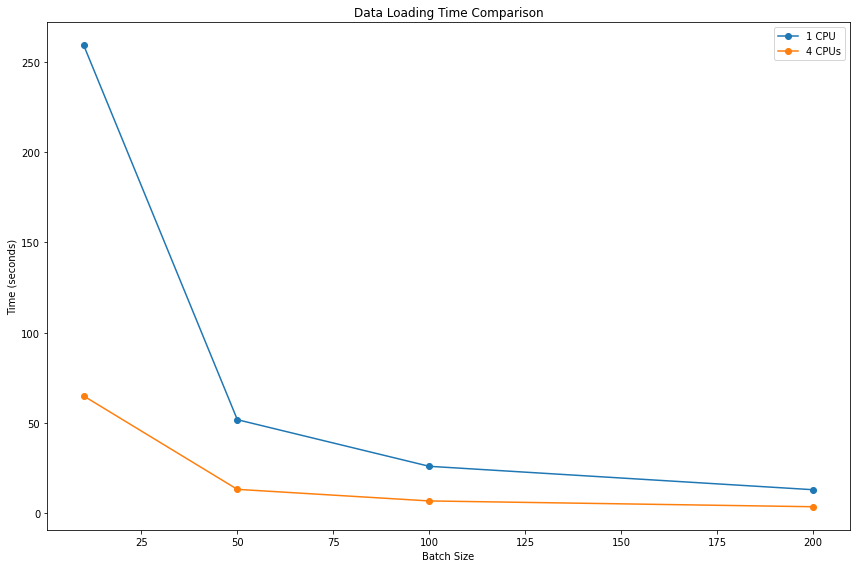

In [15]:
import multiprocessing
import time
import os
import matplotlib.pyplot as plt

# Defining function for reading image files
def read_image_batch(filenames):
    # Simulate data loading operation (e.g., reading from disk)
    time.sleep(0.1)  # Reduced sleep time for faster simulation
    return filenames

# Defining a function to load images from subdirectories and batch process
def load_images_from_subdirectories_batch(data_dir, batch_size):
    subdirectories = [os.path.join(data_dir, subdir) for subdir in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subdir))]
    all_filenames = []
    for subdir in subdirectories:
        filenames = [os.path.join(subdir, filename) for filename in os.listdir(subdir) if not filename.startswith('.')]
        all_filenames.extend(filenames)
    batched_filenames = [all_filenames[i:i + batch_size] for i in range(0, len(all_filenames), batch_size)]
    return batched_filenames

batch_sizes = [10, 50, 100, 200]  # Adjust as needed

# Defining a function to process batches using multiprocessing
def process_batches_with_multiprocessing(batched_tasks, num_cpus):
    pool = multiprocessing.Pool(num_cpus)
    start_time = time.time()
    results = pool.map(read_image_batch, batched_tasks)
    end_time = time.time()
    execution_time = end_time - start_time
    pool.close()
    pool.join()
    return execution_time

# Measuring execution times for different batch sizes on 1 CPU and 4 CPUs
execution_times_1_cpu_list = []
execution_times_4_cpus_list = []

for batch_size in batch_sizes:
    # Creating batched tasks for data loading with the current batch size
    batched_tasks_1_cpu = load_images_from_subdirectories_batch(data_dir, batch_size)  # Load images on 1 CPU
    batched_tasks_4_cpus = load_images_from_subdirectories_batch(data_dir, batch_size)  # Load images on 4 CPUs

    # Measuring execution time for loading data on 1 CPU
    execution_times_1_cpu = process_batches_with_multiprocessing(batched_tasks_1_cpu, 1)
    execution_times_1_cpu_list.append(execution_times_1_cpu)

    # Measuring execution time for loading data on 4 CPUs
    execution_times_4_cpus = process_batches_with_multiprocessing(batched_tasks_4_cpus, 4)
    execution_times_4_cpus_list.append(execution_times_4_cpus)
    
print("execution_times_1_cpu ", execution_times_1_cpu_list)
print("execution_times_4_cpu ", execution_times_4_cpus_list)

# Plotting the execution times for different batch sizes
plt.figure(figsize=(12,8))
plt.plot(batch_sizes, execution_times_1_cpu_list, marker='o', label='1 CPU')
plt.plot(batch_sizes, execution_times_4_cpus_list, marker='o', label='4 CPUs')
plt.xlabel('Batch Size')
plt.ylabel('Time (seconds)')
plt.title('Data Loading Time Comparison')
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
import dask.config
shard_size_bytes = "100MB"  # Adjust the size as needed
dask.config.set({'distributed.comm.shard': shard_size_bytes})
websockets_limit = 1000  # Adjust the limit as needed
dask.config.set({'distributed.comm.websockets.max-connections': websockets_limit})


In [17]:
#Without multiprocessing pool() 
from dask.distributed import Client, LocalCluster
from dask import delayed
import time
import os

# Creating a Dask cluster with 4 workers (CPUs)
cluster = LocalCluster(n_workers=4)
client = Client(cluster)

# Defining delayed function for reading image files
@delayed
def read_image(filename):
    time.sleep(1)  # Simulate loading time (1 second delay)
    return filename

def load_images_from_subdirectories(data_dir):
    subdirectories = [os.path.join(data_dir, subdir) for subdir in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subdir))]
    all_filenames = []
    for subdir in subdirectories:
        filenames = [os.path.join(subdir, filename) for filename in os.listdir(subdir) if not filename.startswith('.')]
        all_filenames.extend(filenames)
    return [read_image(filename) for filename in all_filenames]

delayed_tasks = load_images_from_subdirectories(data_dir)

# Measuring execution time for loading data on 4 CPUs
start_time = time.time()
results = client.compute(delayed_tasks)
results = client.gather(results)  # Wait for data to be computed
end_time = time.time()
execution_time = end_time - start_time

print("Execution Time:", execution_time, "seconds")

# Closing the Dask client and cluster
client.close()
cluster.close()


/home/patel.devki1/.local/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33028 instead
  warnings.warn(


Execution Time: 941.2021579742432 seconds


/home/patel.devki1/.local/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33488 instead
  warnings.warn(


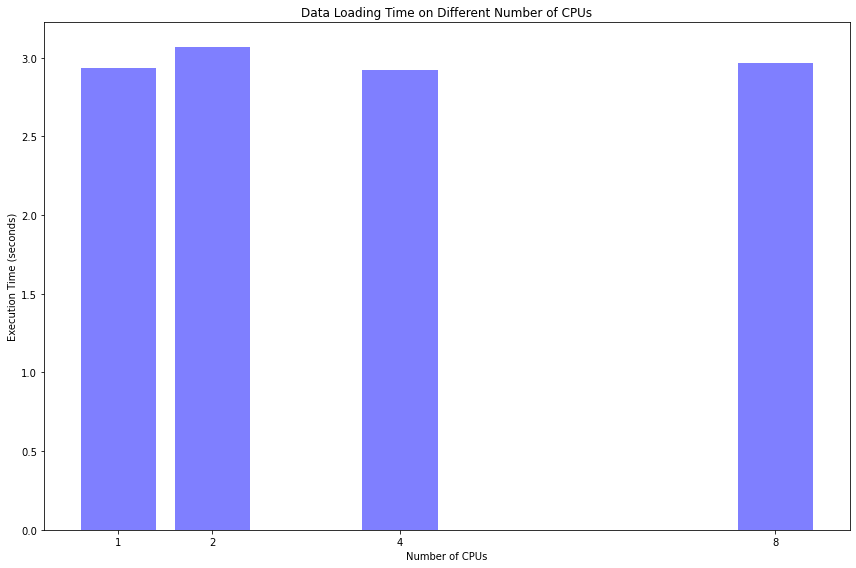

In [18]:
#data loading on 8 CPUs without Multiprocessing pool()
from dask.distributed import Client, LocalCluster
from dask import delayed
import matplotlib.pyplot as plt
import time
import os

# Creating a Dask cluster with 4 workers (CPUs)
cluster = LocalCluster(n_workers=4)
client = Client(cluster)

# Defining delayed function for reading image files
@delayed
def read_image_batch(filenames):
    # Simulate data loading operation (e.g., reading from disk)
    time.sleep(0.1)  # Reduced sleep time for faster simulation
    return filenames

# Defining a function to load images from subdirectories and batch process
def load_images_from_subdirectories_batch(data_dir, batch_size):
    subdirectories = [os.path.join(data_dir, subdir) for subdir in os.listdir(data_dir) if not subdir.startswith('.')]
    all_filenames = []
    for subdir in subdirectories:
        filenames = [os.path.join(subdir, filename) for filename in os.listdir(subdir) if not filename.startswith('.')]
        all_filenames.extend(filenames)
    # Batch process filenames into groups
    batched_filenames = [all_filenames[i:i + batch_size] for i in range(0, len(all_filenames), batch_size)]
    return [read_image_batch(batch) for batch in batched_filenames]

# Defining the directory containing subdirectories
data_dir = "/home/patel.devki1/Dataset/lung_colon_image_set"

batch_size = 50

# Measuring execution times for different numbers of CPUs
num_cpus_list = [1, 2, 4, 8]
execution_times = []

for num_cpus in num_cpus_list:
    # Creating delayed tasks for data loading with the current batch size and number of CPUs
    batched_tasks = load_images_from_subdirectories_batch(data_dir, batch_size)

    # Measuring execution time for loading data with the current number of CPUs
    start_time = time.time()
    _ = client.compute(batched_tasks)
    _ = client.gather(_)  # Wait for data to be computed
    end_time = time.time()
    execution_time = end_time - start_time
    execution_times.append(execution_time)

# Plotting the execution times for different numbers of CPUs
plt.figure(figsize=(12,8))
plt.bar(num_cpus_list, execution_times, color='blue', alpha=0.5)
plt.xlabel('Number of CPUs')
plt.ylabel('Execution Time (seconds)')
plt.title('Data Loading Time on Different Number of CPUs')
plt.xticks(num_cpus_list)
plt.tight_layout()
plt.show()

# Closing the Dask client and cluster
client.close()
cluster.close()


In [19]:
#multiprocessing data loading using multiprocessing.pool()
import multiprocessing
import os
import time

# Defineing a function to read image batches (simulated data loading)
def read_image_batch(filenames):
    # Simulate data loading operation (e.g., reading from disk)
    time.sleep(0.1)  # Reduced sleep time for faster simulation
    return filenames

# Defineing a function to load images from subdirectories and batch process
def load_images_from_subdirectories_batch(data_dir, batch_size):
    subdirectories = [os.path.join(data_dir, subdir) for subdir in os.listdir(data_dir) if not subdir.startswith('.')]
    all_filenames = []
    for subdir in subdirectories:
        filenames = [os.path.join(subdir, filename) for filename in os.listdir(subdir) if not filename.startswith('.')]
        all_filenames.extend(filenames)
    # Batch process filenames into groups
    batched_filenames = [all_filenames[i:i + batch_size] for i in range(0, len(all_filenames), batch_size)]
    return batched_filenames

# Experiment with different batch sizes
batch_size = 100

# Loading images from subdirectories and batch process
batched_filenames = load_images_from_subdirectories_batch(data_dir, batch_size)

# Initialize a multiprocessing pool with the desired number of processes (CPUs)
num_cpus = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=num_cpus)

# Measureing execution time for loading data using multiprocessing.Pool
start_time = time.time()
results = pool.map(read_image_batch, batched_filenames)
end_time = time.time()
execution_time = end_time - start_time

# Closing the multiprocessing pool
pool.close()
pool.join()

# Printing the execution time
print(f"Execution time: {execution_time} seconds")


Execution time: 1.237574577331543 seconds


Execution time: 26.029232263565063 seconds
Execution time: 13.26566481590271 seconds
Execution time: 6.85731053352356 seconds
Execution time: 3.646202325820923 seconds


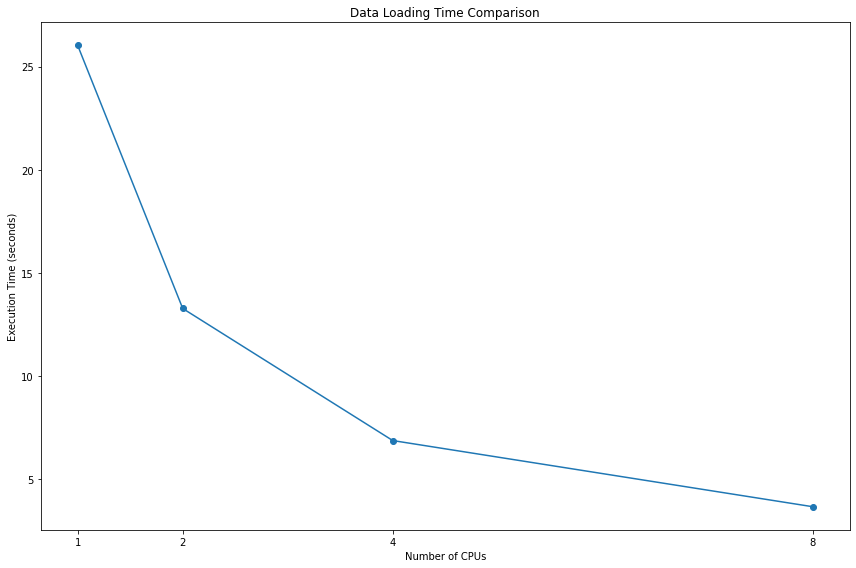

In [23]:
#plotting of difference
import multiprocessing
import os
import time
import matplotlib.pyplot as plt

# Defining a function to read image batches (simulated data loading)
def read_image_batch(filenames):
    # Simulate data loading operation (e.g., reading from disk)
    time.sleep(0.1)  # Reduced sleep time for faster simulation
    return filenames

# Defining a function to load images from subdirectories and batch process
def load_images_from_subdirectories_batch(data_dir, batch_size):
    subdirectories = [os.path.join(data_dir, subdir) for subdir in os.listdir(data_dir) if not subdir.startswith('.')]
    all_filenames = []
    for subdir in subdirectories:
        filenames = [os.path.join(subdir, filename) for filename in os.listdir(subdir) if not filename.startswith('.')]
        all_filenames.extend(filenames)
    batched_filenames = [all_filenames[i:i + batch_size] for i in range(0, len(all_filenames), batch_size)]
    return batched_filenames

batch_size = 100

# Initializing lists to store execution times and number of CPUs
execution_times = []
num_cpus_list = [1, 2, 4, 8]

for num_cpus in num_cpus_list:
    batched_filenames = load_images_from_subdirectories_batch(data_dir, batch_size)

    # Initializing a multiprocessing pool with the desired number of processes (CPUs)
    pool = multiprocessing.Pool(processes=num_cpus)

    # Measuring execution time for loading data using multiprocessing.Pool
    start_time = time.time()
    results = pool.map(read_image_batch, batched_filenames)
    end_time = time.time()
    execution_time = end_time - start_time


    # Closing the multiprocessing pool
    pool.close()
    pool.join()

    execution_times.append(execution_time)
    
    print(f"Execution time: {execution_time} seconds")


# Plotting the execution times for different numbers of CPUs
plt.figure(figsize=(12,8))
plt.plot(num_cpus_list, execution_times, marker='o')
plt.xlabel('Number of CPUs')
plt.ylabel('Execution Time (seconds)')
plt.title('Data Loading Time Comparison')
plt.xticks(num_cpus_list)
plt.tight_layout()
plt.show()


Generate Dask Graph

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.465229 to fit
/home/patel.devki1/.local/lib/python3.8/site-packages/dask/base.py:1368: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.465229 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.465229 to fit
/home/patel.devki1/.local/lib/python3.8/site-packages/dask/base.py:1368: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.465229 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.465229 to fit
/home/patel.devki1/.local/lib/python3.8/site-packages/dask/base.py:1368: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpecte

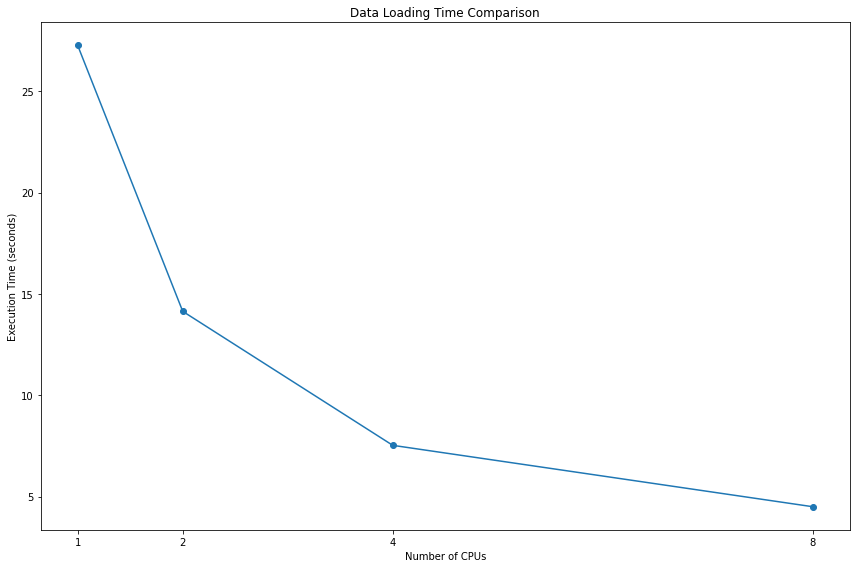

In [25]:
import dask
import dask.multiprocessing
import os
import time
import matplotlib.pyplot as plt

# Defining a function to read image batches (simulated data loading)
def read_image_batch(filenames):
    # Simulate data loading operation (e.g., reading from disk)
    time.sleep(0.1)  # Reduced sleep time for faster simulation
    return filenames

# Defining a function to load images from subdirectories and batch process
def load_images_from_subdirectories_batch(data_dir, batch_size):
    subdirectories = [os.path.join(data_dir, subdir) for subdir in os.listdir(data_dir) if not subdir.startswith('.')]
    all_filenames = []
    for subdir in subdirectories:
        filenames = [os.path.join(subdir, filename) for filename in os.listdir(subdir) if not filename.startswith('.')]
        all_filenames.extend(filenames)
    batched_filenames = [all_filenames[i:i + batch_size] for i in range(0, len(all_filenames), batch_size)]
    return batched_filenames

batch_size = 100

# Initializing lists to store execution times and number of CPUs
execution_times = []
num_cpus_list = [1, 2, 4, 8]

for num_cpus in num_cpus_list:
    # Loading images from subdirectories and batch process
    batched_filenames = load_images_from_subdirectories_batch(data_dir, batch_size)

    # Defining delayed functions using Dask
    delayed_read_image_batch = dask.delayed(read_image_batch)

    # Mapping delayed function over the batched filenames using Dask multiprocessing scheduler
    delayed_results = [delayed_read_image_batch(filenames) for filenames in batched_filenames]
    graph = dask.visualize(delayed_results)

    # Computing the delayed results and measure execution time
    start_time = time.time()
    results = dask.compute(*delayed_results, scheduler='processes', num_workers=num_cpus)
    end_time = time.time()
    execution_time = end_time - start_time

    execution_times.append(execution_time)

    # Plotting the Dask graph (optional, for visualization)
    graph_file = f'dask_graph_{num_cpus}_CPUs.png'
    dask.visualize(delayed_results, filename=graph_file)

# Plotting the execution times for different numbers of CPUs
plt.figure(figsize=(12,8))
plt.plot(num_cpus_list, execution_times, marker='o')
plt.xlabel('Number of CPUs')
plt.ylabel('Execution Time (seconds)')
plt.title('Data Loading Time Comparison')
plt.xticks(num_cpus_list)
plt.tight_layout()
plt.show()
